# Three-body bound state problem

The solution for the three-body bound state problem will again be based on OBEpot classes. 
Therefore, we repeat the methods for defining interaction and for fitting the interaction to the 
given bound state energy.

## Define a two-body interaction

I will work with a class that provides a method for the partial wave projection $V(p,p',l)$ of a bosonic 
interaction.   

A realistic test case is given by a OBE exchange interaction 
$$ V(\vec p, \vec p') = \frac{A}{2\pi} \frac{1}{(\vec p - \vec p')^2 + m_B^2} \exp\left(-\frac{(\vec p - \vec p')^2 + m_B^2}{\Lambda^2 }\right) + \frac{C_0}{4 \pi } \exp\left( - \frac{p^2+{p'}^2}{\Lambda^2}\right) $$ 


In [1]:
# for simplicity, we define the OBE exchange by numerical integration 
# and add one contact term to be determined using either a bound state or a scattering length 

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat



We use the fits of the last lecture to determine the parameters of this OBE interaction. 

In [2]:
parasets=[[300.0, -0.09827953494014054],
 [400.0, -0.028203145146196713],
 [500.0, -0.0004221894040945335],
 [600.0, 0.012857431330421717],
 [700.0, 0.020167185806378923],
 [800.0, 0.024707945457255083],
 [900.0, 0.027865200396659445],
 [1000.0, 0.030308007813785776],
 [1100.0, 0.03239034331482156],
 [1200.0, 0.03431611357447293]]

## Repeat the two-body bound state solver
The class for the calculation of the two-body bound state is added to check parameters and to provide 
the grid definitions for the two-body t-matrix. 

In [3]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d
import timeit

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of two-body solver. 
        
           The initialization defines the momentum grids and the interaction and partial wave to be used. 
           At this time, also the grid for Fourier transformation and for the Fourier transformed 
           wave function is given. 
           
           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb] 
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           mred -- reduces mass of the two bosons in MeV
           
           nr1 -- number of r points in interval [0,rb] 
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""
        
        # measure also time for preparation (mostly from potential)
        self.preptime=-timeit.default_timer() 

        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2 
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.l=l 

        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2 
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four 

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)
 
        # store grid points and weights for r space wave functions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)
        
        # store grid points and weights for Fourier trafo 
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)
        
        # store underlying interaction
        self.pot=pot
        
        # and actual potential matrix elements 
        self.vmat=np.empty((self.npoints,self.npoints),dtype=np.double)
        for i in range(self.npoints):
          for j in range(self.npoints): 
            self.vmat[i,j]=self.pot.v(self.pgrid[i],self.pgrid[j],self.l)

        self.preptime+=timeit.default_timer() 
    
            
        # fix timer for solution of the eigenvalue equations
        self.runtime=0.0
        
    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gauss-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight 

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # measure timeing (compare for loop and einsum)
      self.runtime-=timeit.default_timer() 
    
    # set up the matrix amat for which eigenvalues have to be calculated
    
      amat=np.einsum('i,ij,j->ij', 1.0/(E-self.pgrid**2/(2*self.mred)),self.vmat,self.pweight*self.pgrid**2)   
      # replaces less performant for loops   
      #amat=np.empty((self.npoints,self.npoints),dtype=np.double)
      #for i in range(self.npoints):
      #  for j in range(self.npoints): 
      #    amat[i,j]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))*self.vmat[i,j]*self.pweight[j]*self.pgrid[j]**2)

    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(amat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    # define solution as unnormalized wave function 
      wf=evec[:,maxpos]
    # and normalize 
      norm=np.sum(wf**2*self.pweight[0:self.npoints]*self.pgrid[0:self.npoints]**2)
      wf=1/np.sqrt(norm)*wf
    
    # measure timeing (compare for loop and einsum)
      self.runtime+=timeit.default_timer()
    
      return eigv,self.pgrid[0:self.npoints],wf

    
    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
                  
        return e1,eta1,pgrid,wf 
           
    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.
        
           Parameter: 
           wfp -- wave function in momentum space
            
           Note that the factor I**l is omitted."""
        
        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points  
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        # evaluate jl     
        jlmat = spherical_jn(self.l,rpmat)
        
        # interpolate of wave to denser Fourier trafo grid
        wfinter = interp1d(self.pgrid, wfp, kind='cubic',fill_value="extrapolate")
        # interpolate wf and multiply my p**2*w elementwise 
        wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)
        
        # now the Fourier trafo is a matrix-vector multiplication 
        wfr = jlmat.dot(wfdense)
        
        return self.rgrid,wfr
    
    
    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.
        
           Normalization of the wave function is assumed. 
           Parameter: 
           wfr -- wave function in r-space obtained by previous Fourier trafo"""
        
        
        norm=np.sum(wfr**2*self.rweight*self.rgrid**2)
        rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

            
        rms=np.sqrt(rms)
        
        return norm,rms
    
    
        

Use this to calc binding energies ...

In [4]:
# go through parameters of fit
for para in parasets:
    # determine interacion and set up solver 
    pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
    solver=TwoBody(pot=pot,np1=40,np2=20,pa=1.0,pb=7.0,pc=35.0,mred=938.92/2,l=0,
                            nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=400,np2four=200)
    
    # perform energy search for this parameter set
    ener,lam,pmom,wf=solver.esearch(neigv=1,e1=-2.0/TwoBody.hbarc,e2=-2.5/TwoBody.hbarc)
    
    # get Fourier trafo (together with r grid points)
    rp,wfr=solver.fourier(wf)
    # calculate norm and rms radius (deviation of the norm from 1 gives idea of accuracy)
    norm,rms=solver.rms(wfr)
    
    # print energy, eigenvalue (should be one), norm and 1/2 rms (= radius to the CM for equal mass particles)
    print("{0:15.6e}   {1:15.6e}  {2:15.6e}   {3:15.6e}".format(ener*TwoBody.hbarc,lam, norm, rms/2.0)) #rms is printed for distance to CM assuming equal masses

    
# for some timing statistics print measurements of last runs 

print("Preparatione time: {0:15.6e} sec".format(solver.preptime))
print("Energy search time: {0:15.6e} sec".format(solver.runtime))  


  -2.224997e+00      1.000000e+00  9.997794e-01+0.000000e+00j   2.096766e+00+0.000000e+00j
  -2.224993e+00      1.000000e+00  9.997841e-01+0.000000e+00j   2.069329e+00+0.000000e+00j
  -2.224990e+00      1.000000e+00  9.997849e-01+0.000000e+00j   2.064349e+00+0.000000e+00j
  -2.224991e+00      1.000000e+00  9.997849e-01+0.000000e+00j   2.064681e+00+0.000000e+00j
  -2.224992e+00      1.000000e+00  9.997846e-01+0.000000e+00j   2.066091e+00+0.000000e+00j
  -2.224992e+00      1.000000e+00  9.997844e-01+0.000000e+00j   2.067504e+00+0.000000e+00j
  -2.224993e+00      1.000000e+00     9.997843e-01      2.068679e+00
  -2.224994e+00      1.000000e+00  9.997842e-01+0.000000e+00j   2.069602e+00+0.000000e+00j
  -2.224994e+00      1.000000e+00  9.997841e-01+0.000000e+00j   2.070315e+00+0.000000e+00j
  -2.224991e+00      1.000000e+00  9.997840e-01+0.000000e+00j   2.070864e+00+0.000000e+00j
Preparatione time:    1.258423e+00 sec
Energy search time:    8.128400e-03 sec


looks good! 

## Three-Body bound state

Now comes the new aspects of the three-body bound state problem. 

### Off-shell t-matrix

The first part is the calculation of the off-shell two-body t-matrix. The equation to be solved is 
$$ t(p,p',E') = V(p,p') +  \int_0^\infty dp'' {p''}^2 V(p,p'') \frac{1}{E-\frac{{p''}^2}{2 \mu}} t(p'',p',E') $$
where the energy is given by $E'=E - 0.75\,q^2/m$ by the energy of the three-body system and the kinetic energy of the spectator.
The implementation is done as an extension of the two-body bound state class so that some of the previous routines can be reused. 
The initialization just adds points for the spectator momentum (and also for the definition of a Fourier transformed wave function). For the bound state problem, we do not need to take any singularity into account since $E$ is negative.

In [5]:
# next extend the class for twobody to scattering 
from scipy.special import legendre
import timeit 

class TwoBodyTMat(TwoBody):
    """This class defines the off-shell t-matrix for a three-body bound state.
    
       The class assumes three identical particles. It also contains the 
       initialization of grid points for the three-body problem. 
    """
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, 
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0, 
                            mass=938.92,lmax=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            nrho1=20, nrho2=10, rhoa=1.0, rhob=5.0, rhoc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of grid points and interaction for the solution of the three-body problem. 
        
           Parameter: 
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of p grid points in interval [0,pb] 
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           nq1 -- number of q grid points in interval [0,qb] 
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above 
           qc  -- upper integration boundary for the solution of the integral equation 
           mass -- particle mass of the three identical bosons in MeV
           
           nr1 -- number of r (related to p) points in interval [0,rb] 
           nr2 -- number of r (related to p) points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,ra]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           nrho1 -- number of rho (related to q) points in interval [0,rhob] 
           nrho2 -- number of rho (related to q) points in interval [rhob,rhoc]
           rhoa  -- half of np1 points are in interval [0,rhoa]
           rhob  -- interval boundary as defined above 
           rhoc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo
           
           lmax  -- maximal two-body angular momentum to be taken into account
           """
        
        
        # first use the TwoBody class to keep the main parameters 
        super().__init__(pot,np1,np2,pa,pb,pc,mass/2,0,nr1,nr2,ra,rb,rc,np1four,np2four)

        self.nq1 = nq1
        self.nq2 = nq2
        self.nqpoints  = nq1+nq2 
        self.mass=mass/self.hbarc
        self.qa=qa
        self.qb=qb
        self.qc=qc
        self.lmax=lmax 

        self.nrho1 = nrho1
        self.nrho2 = nrho2
        self.nrhopoints  = nrho1+nrho2 
        self.rhoa=rhoa
        self.rhob=rhob
        self.rhoc=rhoc


        # store grid points and weights for integral equations
        self.qgrid,self.qweight = self._trns(self.nq1,self.nq2,self.qa,self.qb,self.qc)
 
        # store grid points and weights for r space wave functions
        self.rhogrid,self.rhoweight = self._trns(self.nrho1,self.nrho2,self.rhoa,self.rhob,self.rhoc)
        
        # store grid points and weights for Fourier trafo 
        self.qfourgrid,self.qfourweight = self._trns(self.np1four,self.np2four,self.qa,self.qb,self.qc)
        
        # and prepare actual potential matrix elements for all angular momenta
        self.vmatpw=np.empty((self.npoints,self.npoints,self.lmax+1),dtype=np.double)
        for l in range(self.lmax+1):
         for i in range(self.npoints):
          for j in range(self.npoints):
            if l==0:
              self.vmatpw[i,j,l]=self.vmat[i,j]  
            else:    
              self.vmatpw[i,j,l]=self.pot.v(self.pgrid[i],self.pgrid[j],l)
        
        self.tmattime=0.0
        
# now turn to scattering and solve for LS equation to get tmatrix (on- and offshell)
    def prep_tmat(self,E):
      """Prepares all necessary t-matrix elements up to l=lmax.
      
         Starts the calculation of the t-matrix for a given three-body energy. 
      """  
      self.tmattime-=timeit.default_timer() 
      # prepare off-shell energies for t-matrix 
      etmat=E-0.75*self.qgrid**2/self.mass   # note that this is a negative energy < E_b(two-body) 
             
      # prepare numpy array that keeps all tmatrix elements 
      tmat=np.empty((self.lmax+1,self.nqpoints,self.npoints,self.npoints),dtype=np.double)
      
      # now I need to solve the Lippmann-Schwinger equation for each etmat and each l =0,..,lmax
      for l in range(self.lmax+1):
        for ie in range(self.nqpoints): 
            
          # define matrix for set of equations 
          # predefine the Kronecker deltas 
          amat=np.identity(self.npoints,dtype=np.double)
          # now add the second part of the definition of the matrix   
          #for i in range(self.npoints):
          #  for j in range(self.npoints):
          #     amat[i,j]+=-self.vmatpw[i,j,l]*self.pgrid[j]**2 \
          #                     /(etmat[ie]-self.pgrid[j]**2/(2*self.mred))*self.pweight[j]  \  

          amat-=np.einsum("ij,j->ij",self.vmatpw[:,:,l],self.pgrid[:]**2 \
                               /(etmat[ie]-self.pgrid[:]**2/(2*self.mred))*self.pweight[:])
            
              
        
          # now define the rhs   
#          bmat=np.empty((self.npoints,self.npoints),dtype=np.double)
#          for i in range(self.npoints):
#           for j in range(self.npoints):   
#             bmat[i,j]=self.vmatpw[i,j,l]

          bmat=self.vmatpw[:,:,l]
    
          # finally solve set of equations and store in complete array 
          tmat[l,ie,:,:]=np.linalg.solve(amat,bmat)
        
      self.tmattime+=timeit.default_timer() 
      # return offshell matrix for all energies and angular momenta   
      return tmat
            


In [6]:
pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
solver = TwoBodyTMat(pot, lmax=0)
tmat = solver.prep_tmat(-19)
# tmat.shape
solver.tmattime

0.04015989999999903

### Spline interpolation
For the interpolation, it is necessary to find a representation of the interpolated function that can be expressed 
as a sum 
$$ f(x) = \sum_{i=0}^{n-1} f(x_i) \ S_i(x) $$ 
where $x_i$ are defined a priori. $S_i(x)$ needs to be defined only based on $x$ and $x_i$. 
We will use here a simple ansatz: for $x_{i+1}>x>x_i$, we will use the grid points $x_{i-1}$, $x_{i}$$x_{i+1}$  and  $x_{i+2}$ 
to define 
\begin{eqnarray}
S_{i-1}(x)& =& -\phi_3(x) \frac{x_{i+1}-x_{i}}{(x_{i}-x_{i-1})(x_{i+1}-x_{i-1})} \\
S_{i}(x)& =& \phi_1(x) + \phi_3(x) \left( \frac{x_{i+1}-x_{i}}{(x_{i}-x_{i-1})(x_{i+1}-x_{i-1})} - \frac{x_{i}-x_{i-1}}{(x_{i+1}-x_{i})(x_{i+1}-x_{i-1})} \right) - \phi_4(x) \frac{x_{i+2}-x_{i+1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i})}\\
S_{i+1}(x)& =& \phi_2(x) + \phi_3(x) \frac{x_{i}-x_{i-1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i-1})}  + \phi_4(x)  \left( \frac{x_{i+2}-x_{i+1}}{(x_{i+1}-x_{i})(x_{i+2}-x_{i})} - \frac{x_{i+1}-x_{i}}{(x_{i+2}-x_{i+1})(x_{i+2}-x_{i})} \right)
\\
S_{i+2}(x)& =& \phi_4(x) \frac{x_{i+1}-x_{i}}{(x_{i+2}-x_{i+1})(x_{i+2}-x_{i})} \\
\end{eqnarray}
where 
\begin{eqnarray}
\phi_{{1}} \left( x \right) & = & {\frac { \left( x_{{i+1}}-x \right) ^{2}
 \left( x_{{i+1}}-3\,x_{{i}}+2\,x \right) }{ \left( x_{{i+1}}-x_{{i}}
 \right) ^{3}}} \\
\phi_{{2}} \left( x \right) & = & {\frac { \left( x_{{i}}-x \right) ^{2}
 \left( 3\,x_{{i+1}}-x_{{i}}-2\,x \right) }{ \left( x_{{i+1}}-x_{{i}}
 \right) ^{3}}} \\
\phi_{{3}} \left( x \right) & = & {\frac { \left( x-x_{{i}} \right) 
 \left( x_{{i+1}}-x \right) ^{2}}{ \left( x_{{i+1}}-x_{{i}} \right) ^{
2}}} \\
\phi_{{4}} \left( x \right) & = & {\frac { \left( x-x_{{i+1}} \right) 
 \left( x_{{i}}-x \right) ^{2}}{ \left( x_{{i+1}}-x_{{i}} \right) ^{2}
}} \\
\end{eqnarray}
are polynomials with 
\begin{eqnarray}
\phi_2(x_{i})& = & \phi_3(x_{i})=\phi_4(x_{i})=0 \\
\phi_1'(x_{i}) &= & \phi_2'(x_{i})=\phi_4'(x_{i})=0 \\ 
\phi_1(x_{i+1})& = & \phi_3(x_{i+1})=\phi_4(x_{i+1})=0 \\
\phi_1'(x_{i+1}) &= & \phi_2'(x_{i+1})=\phi_3'(x_{i+1})=0 \\ 
\end{eqnarray}
and 
\begin{eqnarray}
\phi_1(x_{i})& = & \phi_2(x_{i+1})=\phi_3'(x_{i})=\phi_4'(x_{i+1})=1 \\
\end{eqnarray}






In [6]:
import numpy as np
# prepare interpolation using cubic hermitian splines 

class Cubherm:
    """Prepares spline functions for cubic hermitian splines. 
    
    see Hueber et al. FBS 22,107 (1997). 
    
    The function spl returns the the spline function for a given x. 
    If x is below the smallest grid point, extrapolation is used. 
    If x is after largest grid point, then the function evaluates to zero. 
    """
    
        
    def spl(xold,xin):
        """Calculates spline functions for given values xold and xnew.
        
           Parameters:
           xold -- set of grid points where function is given. xold needs to be one dimensional.
           xnew -- set of grid points to interpolate to. xnew can be multidimensional. 
           
           On return spline functions will be given that have the shape of xnew and xold combined. 
        """
        
        # first determine the base value of the index for each xnew.
        
        nold=len(xold)
        if nold<4:
          raise(ValueError("Interpolation requires at least 4 grid points.")) 
        
        xnew=xin.reshape((-1))        
        indx=np.empty((len(xnew)),dtype=int)
        
        for i in range(len(xnew)):
          # do not extrapolated beyond largest grid point
          if xnew[i] > xold[nold-1]: 
            indx[i]=-1
          else:  
            for j in range(nold):
              if xnew[i] <= xold[j]:
                break          
            if j < 1:
              indx[i]=0
            elif j > nold-3:
              indx[i]=nold-3
            else:
              indx[i]=j-1  

        # then prepare phi polynomials for each x 
        
        phi1=np.zeros((len(xnew)),dtype=np.double)
        phi2=np.zeros((len(xnew)),dtype=np.double)
        phi3=np.zeros((len(xnew)),dtype=np.double)
        phi4=np.zeros((len(xnew)),dtype=np.double)
        
        for i in range(len(xnew)):
          if indx[i]>0:  
            phi1[i] = (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (xold[indx[i] + 1] - 3 * xold[indx[i]] + 2 * xnew[i])
            phi2[i] = (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 3 * (3 * xold[indx[i] + 1] - xold[indx[i]] - 2 * xnew[i])
            phi3[i] = (xnew[i] - xold[indx[i]]) * (xold[indx[i] + 1] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
            phi4[i] = (xnew[i] - xold[indx[i] + 1]) * (xold[indx[i]] - xnew[i]) ** 2 / (xold[indx[i] + 1] - xold[indx[i]]) ** 2
        
        # now we are ready to prepare the spline functions 
        # most are zero 
        splfu=np.zeros((len(xold),len(xnew)),dtype=np.double)
        for i in range(len(xnew)):
          if indx[i]>0:  
            splfu[indx[i]-1,i] = \
               -phi3[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]]-xold[indx[i]-1])*(xold[indx[i]+1]-xold[indx[i]-1]))
            
            splfu[indx[i],i] = phi1[i] \
                +phi3[i]*((xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]]-xold[indx[i]-1]) \
                         -(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]]))/(xold[indx[i]+1]-xold[indx[i]-1]) \
                -phi4[i]*(xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+2]-xold[indx[i]])

            splfu[indx[i]+1,i] = phi2[i] \
                +phi3[i]*(xold[indx[i]]-xold[indx[i]-1])/ (xold[indx[i]+1]-xold[indx[i]])/(xold[indx[i]+1]-xold[indx[i]-1]) \
                +phi4[i]*((xold[indx[i]+2]-xold[indx[i]+1])/ (xold[indx[i]+1]-xold[indx[i]]) \
                         -(xold[indx[i]+1]-xold[indx[i]])/ (xold[indx[i]+2]-xold[indx[i]+1]))/(xold[indx[i]+2]-xold[indx[i]])
            
            
            splfu[indx[i]+2,i] = \
                phi4[i]*(xold[indx[i]+1]-xold[indx[i]])/(
                        (xold[indx[i]+2]-xold[indx[i]+1])*(xold[indx[i]+2]-xold[indx[i]]))
          elif indx[i]>=0:
            # do linear interpolation at the origin 
            splfu[indx[i],i] = (xnew[i]-xold[indx[i]+1])/(xold[indx[i]]-xold[indx[i]+1]) 
            splfu[indx[i]+1,i] = (xold[indx[i]]-xnew[i])/(xold[indx[i]]-xold[indx[i]+1]) 

        retshape=[nold] 
        for n in list(np.shape(xin)):
          retshape.append(n)
        
        return splfu.reshape(retshape)
    

The following cell is just for testing the interpolation routines. 

   1.000000e-02     5.149358e-06    9.999000e-02 
   1.905025e-01    -1.461695e-05    9.980920e-02 
   3.710050e-01     2.346370e-04    9.960371e-02 
   5.515075e-01     2.671462e-04    9.917095e-02 
   7.320101e-01    -3.325779e-04    9.776651e-02 
   9.125126e-01    -7.852833e-04    9.368293e-02 
   1.093015e+00     2.516656e-05    8.450394e-02 
   1.273518e+00    -1.688499e-03    6.920928e-02 
   1.454020e+00    -1.215464e-03    5.067225e-02 
   1.634523e+00     2.919026e-03    3.384228e-02 
   1.815025e+00     1.898543e-03    2.146401e-02 
   1.995528e+00    -2.104937e-03    1.340116e-02 
   2.176030e+00    -3.691891e-03    8.423003e-03 
   2.356533e+00    -2.222634e-03    5.388626e-03 
   2.537035e+00     7.978989e-04    3.523988e-03 
   2.717538e+00     1.397672e-03    2.357726e-03 
   2.898040e+00     3.687842e-04    1.612567e-03 
   3.078543e+00    -8.034412e-04    1.125867e-03 
   3.259045e+00    -1.523899e-03    8.011142e-04 
   3.439548e+00    -1.649727e-03    5.800150e-04 


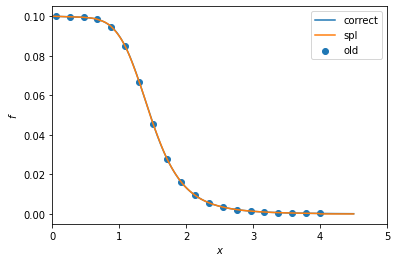

In [7]:
# test the function above 
import matplotlib.pyplot as plt

# get figure enviroment 
fig, ax = plt.subplots()

# set labels 
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$f$')
ax.set_xlim([0,5])
def testfu(x):
    return 1.0/(10.0+x**6)*np.exp(-0.01*x)

xold = np.linspace(0.05,4,20)
                
fold =testfu(xold)
                
                
# xnew = np.outer(np.linspace(0.01,4.5,5),np.linspace(0.01,4.5,10))
xnew = np.linspace(0.01,4.5,200) 
fnew=testfu(xnew)

spl=Cubherm.spl(xold,xnew)
fspl=np.zeros(xnew.shape,dtype=np.double)
for n in range(len(xold)):
  fspl=fspl+spl[n,:]*fold[n]

xprint=xnew.reshape(-1)
fsplprint=fspl.reshape(-1)
fprint=fnew.reshape(-1)


ax.scatter(xold,fold,label=r"old")
ax.plot(xprint,fprint,label=r"correct")
ax.plot(xprint,fsplprint,label=r"spl")

ax.legend(loc="best")
    
fig.savefig("spltest.pdf")    

for i in range(0,len(fprint),8):  
  print("{0:15.6e}  {1:15.6e} {2:15.6e} ".format(xprint[i],(fsplprint[i]-fprint[i])/fprint[i],fprint[i]))

Yes. Interpolation works!

### Three-Body kernel
For the three-body equation, we additionally need the permutation operator and the combination to the matrix $K$. This is implemented 
in an extension of the TwoBody class. The initialization needs to add a set of partial waves and a set of angular grid points for the permutation operators and prepares the $G$ functions and 
spline functions. 

In [8]:
# definition of a ThreeBody class for the calculation of bound states
from numpy.polynomial.legendre import leggauss
from scipy.special import sph_harm
from sympy.physics.quantum.cg import CG


class ThreeBody(TwoBodyTMat):
    """Provides routines for the implementation of the permutation operator and application of the bound state kernel."""
        
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, 
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0, 
                            nx=12,
                            mass=938.92,lmax=0,bl=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            nrho1=20, nrho2=10, rhoa=1.0, rhob=5.0, rhoc=20.0, 
                            np1four=200,np2four=100):     
        """Initializes the permutation operator for the three-body calculation and prepares application of Faddeev kernel.
        
           Parameters: 
           
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of p grid points in interval [0,pb] 
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           nq1 -- number of q grid points in interval [0,qb] 
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above 
           qc  -- upper integration boundary for the solution of the integral equation 
           
           nx -- angular grid points for the permutation operator
           
           mass -- particle mass of the three identical bosons in MeV
           
           nr1 -- number of r (related to p) points in interval [0,rb] 
           nr2 -- number of r (related to p) points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,ra]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           nrho1 -- number of rho (related to q) points in interval [0,rhob] 
           nrho2 -- number of rho (related to q) points in interval [rhob,rhoc]
           rhoa  -- half of np1 points are in interval [0,rhoa]
           rhob  -- interval boundary as defined above 
           rhoc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo
           
           lmax  -- maximal two-body angular momentum to be taken into account    
           bl    -- total orbital angular momentum L ("big l")           
        """
        
        # first initialize the tmatrix class (do not calc the tmatrix yet)
        super().__init__(pot,np1,np2,pa,pb,pc,nq1,nq2,qa,qb,qc,
                         mass,lmax,
                         nr1,nr2,ra,rb,rc,nrho1,nrho2,rhoa,rhob,rhoc,
                         np1four,np2four)
        
        # prepare angular grid points for the permutation operator 
        self.nx=nx
        self.xp,self.xw = leggauss(nx)
        
        # prepare partial wave channels for total angular momentum bl
        # the preparation of a table of allowed combinations is useful 
        # for L != 0 (then l=l12 and lam=l3 can be different from each other)
        self.bl=bl
        self.lammax=lmax+bl
        self.qnalpha=[]
        alpha=0
        for l in range(lmax+1):
          if(l%2==0):   # take only symmetric pw (Pauli)  
           for lam in range(abs(l-bl),l+bl+1):
             self.qnalpha.append({"alpha":alpha,"l":l,"lam":lam,"bl":bl})
             alpha+=1
        self.nalpha=len(self.qnalpha)
        
        self.gpreptime=-timeit.default_timer()        
        # this prepares the G function and splines to be used for the preparation of the 
        # kernel later (pmat = permutation matrix)
        self.pmat=self._prep_perm()
        self.gpreptime+=timeit.default_timer()

        self.fadpreptime=0
        self.fadsolvetime=0
        
    def _angle(self,px,py,pz):
        """Auxiliary routine to determine magnitude, phi, and theta of three component vector. 
        
           Parameters:
           px,py,pz -- cartesian components of a vector 
           
           returns magntitude, theta and phi angles.
        """
    
        pmag=np.sqrt(px**2+py**2+pz**2)
        theta=np.where(pmag!=0.0,np.arccos(pz/pmag),0.0)
             
        phi=theta # copy shape of theta to phi 
        phi=1.5*m.pi # and set to constant value
        
        # prepare bool arrays for px,py > 0 < 0  with shape of phi 
        
        pxgt0=(phi==0)  # copy shape
        pxgt0=(px>0)    # test 

        pxlt0=(phi==0)  # copy shape
        pxlt0=(px<0)    # test 

        pxeq0=(phi==0)  # copy shape
        pxeq0=(px==0)   # test 

        pygt0=(phi==0)  # copy shape
        pygt0=(py>0)    # test 
                      
        np.where(pxgt0 & pygt0,np.arctan(py/px),phi)
        np.where(pxgt0 & np.invert(pxgt0),2*m.pi-np.arctan(-py/px),phi)
        np.where(pxlt0 & pygt0,m.pi-np.arctan(-py/px),phi)
        np.where(pxlt0 & np.invert(pygt0),m.pi+np.arctan(py/px),phi)
        np.where(pxeq0 & pygt0,0.5*m.pi,phi)
            
        return pmag,theta,phi     
    
    
    def _lmindx(self,l,m):
        """Combined unique index for l and m.
        
           Nice trick: since quantum numbers lm are linked to each other, this combined 
           index allows one to store the results depending on lm using the memory more efficiently. 
        """        
        return l**2+l+m
      
        
    def _prep_perm(self):
        """Prepares and return an array for the application of the permutation operator.
        
           The matrix is based on G_{alpha,alphap}(q,qp,x) and is combined to be 
           directly applicable to be summed  with tmatrix.
        """
        
        # prepare shifted momenta and angles for the symmetric permutation 
        pip=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)        
        pi=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)        
        
        thetap=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        theta=np.empty((self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        thetapp=np.empty((self.nx),dtype=np.double)
        
        for ix in range(self.nx):
          xval=self.xp[ix] 
          thetapp[ix]=np.arccos(xval)
          for jq in range(self.nqpoints):
            qpval=self.qgrid[jq]
            for iq in range(self.nqpoints):
              qval=self.qgrid[iq]
            
              px=qpval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=0.5*qval+qpval*xval 
              pi[iq,jq,ix],theta[iq,jq,ix],phi=self._angle(px,py,pz)
                
              px=-0.5*qpval*np.sqrt(1.0-xval**2)
              py=0.0
              pz=-qval-0.5*qpval*xval 
              pip[iq,jq,ix],thetap[iq,jq,ix],phi=self._angle(px,py,pz)

        # prepare spherical harmonics and store based on lmindx 
        # number of lam,mu und l,mu combinations 
        nlamindx=self._lmindx(self.lammax,self.lammax)+1
        nlindx=self._lmindx(self.lmax,self.lmax)+1
        
        # array for Y_{lam mu}(hat qp) (real is sufficient since phi=0)
        ylam=np.empty((nlamindx,self.nx),dtype=np.double)
        for lam in range(self.lammax+1):
          for mu in range(-lam,lam+1):
            ylam[self._lmindx(lam,mu),:]=np.real(sph_harm(mu,lam, 0, thetapp))
        
        
        # array for Y_{l mu}(-q-0.5qp) (real is sufficient since phi=0)
        yl=np.empty((nlindx,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for l in range(self.lmax+1):
          for mu in range(-l,l+1):
            yl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, 0, thetap))
        
        # array for Y*_{l mu}(0.5q+qp) (real is sufficient since phi=0)
        ystarl=np.empty((nlindx,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for l in range(self.lmax+1):
          for mu in range(-l,l+1):
            ystarl[self._lmindx(l,mu),:,:,:]=np.real(sph_harm(mu,l, 0, theta))
        
        # now prepare the necessary Clebsch-Gordan coefficients
        # we need (l lam L, M 0 M)  and (l lam L,mu M-mu,M)
        # I assume that L is smaller than the lmax or lammax therefore M=-L,L
        # the smallest index for storage 
        
        cg=np.zeros((self.nalpha,2*self.bl+1),dtype=np.double)
        cgp=np.zeros((self.nalpha,2*self.lmax+1,2*self.bl+1),dtype=np.double)
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          for bm in range(-self.bl,self.bl+1):
            cg[qnset["alpha"],bm+self.bl]=float(CG(qnset["l"],bm,qnset["lam"],0,self.bl,bm).doit())
            for mu in range(-qnset["l"],qnset["l"]+1):
              cgp[qnset["alpha"],mu+qnset["l"],bm+self.bl]=float(CG(qnset["l"],mu,qnset["lam"],bm-mu,self.bl,bm).doit())

        # now we can perform the mu summation for the combination of coupled spherical harmonics 
        ylylam=np.zeros((self.nalpha,2*self.bl+1,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alphap=qnset["alpha"]
          l=qnset["l"]
          lam=qnset["lam"]
          for bm in range(-self.bl,self.bl+1):
            for mu in range(-l,l+1):
              lmindx=self._lmindx(l,mu)
              if abs(bm-mu)<=lam:
                lamindx=self._lmindx(lam,bm-mu)
                ylylam[alphap,bm+self.bl,:,:,:]+=cgp[alphap,mu+l,bm+self.bl]*yl[lmindx,:,:,:]*ylam[lamindx,:]
                
        # bm summation then gives G 
        gfunc=np.zeros((self.nalpha,self.nalpha,self.nqpoints,self.nqpoints,self.nx),dtype=np.double)
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alpha=qnset["alpha"]
          l=qnset["l"]
          lam=qnset["lam"]
          for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            for bm in range(-self.bl,self.bl+1):
              if(abs(bm)<=l):  
                lmindx=self._lmindx(l,bm) 
                gfunc[alpha,alphap,:,:,:]+=8*m.pi**2*np.sqrt((2*lam+1)/(4*m.pi))/(2*self.bl+1) \
                   *ystarl[lmindx,:,:,:]*ylylam[alphap,bm+self.bl,:,:,:]
            
        #  now we assume that there is a function on p on the left defined by p**l and on the right devided by p'**l' 
        # that is interpolated using Cubherm to pi and pip 
        
        # set spline elements based on grid points and shifted momenta 
        splpi=Cubherm.spl(self.pgrid,pi)
        splpip=Cubherm.spl(self.pgrid,pip)
        
        # interpolation fspl=np.sum(spl*fold,axis=1) first axis is pgrid 
        # prepare splines multiplied by p**l factors (splalpha also includes the integration weights for q' and x integral)
        
        splalpha=np.empty((self.npoints*self.nqpoints*self.nalpha,self.nqpoints,self.nx),dtype=np.double)
        splalphap=np.empty((self.npoints*self.nqpoints*self.nalpha,self.nqpoints,self.nx),dtype=np.double)
        
        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alpha=qnset["alpha"]
          l=qnset["l"]
          for ip in range(self.npoints): 
           for iq in range(self.nqpoints):
             indxpmat=self.npoints*self.nqpoints*alpha+self.npoints*iq+ip
             #for jq in range(self.nqpoints):
             #   splalpha[indxpmat,jq,:]=splpi[ip,iq,jq,:]*(pi[iq,jq,:]/self.pgrid[ip])**l*self.xw[:]*self.qweight[jq]*self.qgrid[jq]**2
             #   splalphap[indxpmat,jq,:]=splpip[ip,jq,iq,:]*(pip[jq,iq,:]/self.pgrid[ip])**l
             splalpha[indxpmat,:,:]=np.einsum("ij,j,i->ij",splpi[ip,iq,:,:]*(pi[iq,:,:]/self.pgrid[ip])**l,self.xw[:],self.qweight[:]*self.qgrid[:]**2)
             splalphap[indxpmat,:,:]=splpip[ip,:,iq,:]*(pip[:,iq,:]/self.pgrid[ip])**l
            
        
        pmat=np.empty((self.npoints*self.nqpoints*self.nalpha,self.npoints*self.nqpoints*self.nalpha),dtype=np.double)

        for qnset in self.qnalpha:  # go through allowed l,lam combinations
          alpha=qnset["alpha"]
          for qnsetp in self.qnalpha:  # go through allowed l,lam combinations
            alphap=qnsetp["alpha"]
            for ip in range(self.npoints): 
             for iq in range(self.nqpoints):
              indxpmat=self.npoints*self.nqpoints*alpha+self.npoints*iq+ip
              for jp in range(self.npoints): 
               for jq in range(self.nqpoints):
                indxpmatp=self.npoints*self.nqpoints*alphap+self.npoints*jq+jp
                pmat[indxpmat,indxpmatp]=np.sum(splalpha[indxpmat,jq,:]
                              *gfunc[alpha,alphap,iq,jq,:]
                              *splalphap[indxpmatp,iq,:])                   
                                      
        return pmat
        
    def prep_faddeev(self,ener):
        """Prepares the Faddeev kernel as a matrix using only two-body interactions.
        
           Parameter:
           ener -- three-body energy in fm-1
        """
 
        # get tmatrix for given energy
        self.tmat=self.prep_tmat(ener)
        
        self.fadpreptime-=timeit.default_timer()
        
        # use matrix multiplication of preprepared permutation matrix 
        # self.pmat[indxpmat,indxpmatp] contains permutation matrix 
        # indexpmat is alpha,iq,ip 

        self.kfadmat=np.zeros(self.pmat.shape,dtype=np.double)
        
        for qnset in self.qnalpha:
          l=qnset["l"] 
          alpha=qnset["alpha"]
          for iq in range(self.nqpoints):
            for ip in range(self.npoints):
              indxkmat=ip+self.npoints*iq+self.npoints*self.nqpoints*alpha
              for jp in range(self.npoints):
                indxpmat=jp+self.npoints*iq+self.npoints*self.nqpoints*alpha
                self.kfadmat[indxkmat,:]+=self.tmat[l,iq,ip,jp]*2*self.pmat[indxpmat,:]
    
        # now multiply with G0
        
        G0=np.empty((self.nqpoints,self.npoints),dtype=np.double)
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            G0[iq,ip]=1.0/(ener-0.75*self.qgrid[iq]**2/self.mass-self.pgrid[ip]**2/self.mass )
        
        for alpha in range(self.nalpha):
          for iq in range(self.nqpoints):
            for ip in range(self.npoints):
              indxkmat=ip+self.npoints*iq+self.npoints*self.nqpoints*alpha
              self.kfadmat[indxkmat,:]*=G0[iq,ip]  

        self.fadpreptime+=timeit.default_timer()

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve three-body Faddev equation and return n-th eigenvalue and Faddeev component. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # set up the matrix for the Faddeev equations
      self.prep_faddeev(E)
      self.fadsolvetime-=timeit.default_timer()
        
    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(self.kfadmat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    
    # define solution as unnormalized Faddeev component 
      fadcomp=np.real(evec[:,maxpos])
          
    # and normalize using permutation again 
      fadtmp=2.0*self.pmat.dot(fadcomp)
        
      norm=0.0  
      for alpha in range(self.nalpha):
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            indxkmat=ip+self.npoints*iq+self.npoints*self.nqpoints*alpha
            norm+=fadcomp[indxkmat]*fadtmp[indxkmat]*self.qweight[iq]*self.qgrid[iq]**2
            
      fadcomp=fadcomp.reshape((self.nalpha,self.nqpoints,self.npoints))     
      norm+=self.skalp(fadcomp,fadcomp)  
      norm*=3.0
        
      fadcomp=(1/np.sqrt(norm))*fadcomp
    
      self.fadsolvetime+=timeit.default_timer()
      return eigv,fadcomp
                
    def esearch(self,neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,fadcomp=self.eigv(e1,neigv)
        eta2,fadcomp=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,fadcomp=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
            
        return e1,eta1,fadcomp 
    
    # the following methods are only useful for testing at this point and can be 
    # ignored at first reading
    
    def faddeev(self,psiin,ener):
        """Applies the Faddeev kernel using only two-body interactions.
        
           Parameter:
           psiin -- incoming Faddeev component
           ener -- three-body energy in fm-1
           
        """
        
        # use matrix multiplication of preprepared permutation matrix 
        psitmp=2.0*self.pmat.dot(psiin.reshape(-1)).reshape(psiin.shape)
        
        # get tmatrix for given energy
        tmat=self.prep_tmat(ener)

        psiout=np.empty(psiin.shape)
        
        for qnset in self.qnalpha:
          l=qnset["l"] 
          alpha=qnset["alpha"]
          for iq in range(self.nqpoints):
            for ip in range(self.npoints):
              psiout[alpha,iq,ip]=np.sum(tmat[l,iq,ip,:]*psitmp[alpha,iq,:])
        
        # now multiply with G0
        
        G0=np.empty((self.nqpoints,self.npoints),dtype=np.double)
        for iq in range(self.nqpoints):
          for ip in range(self.npoints):
            G0[iq,ip]=1.0/(ener-0.75*self.qgrid[iq]**2/self.mass-self.pgrid[ip]**2/self.mass )
        
        for alpha in range(self.nalpha):
          psiout[alpha,:,:]=psiout[alpha,:,:]*G0  
        
        return psiout
        
    
    # the following routines are useful for testing the code. 
    
    def skalp(self,psi1,psi2):
        """Calculate scalar product of two wave functions."""
        
        # multiply with integation weights 
        psitmp=np.zeros((self.nalpha,self.nqpoints,self.npoints),dtype=np.double)        
        for alpha in range(self.nalpha):
         for iq in range(self.nqpoints):
          for ip in range(self.npoints):
           psitmp[alpha,iq,ip]=psi2[alpha,iq,ip] \
                                   *self.pweight[ip]*self.pgrid[ip]**2  \
                                   *self.qweight[iq]*self.qgrid[iq]**2
        return np.sum(psi1*psitmp)
    
    def testperm(self,psi1,psi2):
        """Test permutation matrix."""
        
        # first scalar product without permutation 
        product=self.skalp(psi1,psi2)
        
        # now apply permutation 
        psitmp=self.pmat.dot(psi2.reshape(-1)).reshape(psi2.shape)

        # and build the scalar product (only q integration is necessary)
        for iq in range(self.nqpoints):
           psitmp[:,iq,:] = psitmp[:,iq,:] * self.qgrid[iq]**2*self.qweight[iq]
        
        permprod=np.sum(psitmp*psi1)
    
        print("Permutation test:  {0:15.6e}   {1:15.6e}".format(product,permprod))
    
    def testfu(self):
        """Prepares a fully symmetrical wave function."""
        
        psitmp=np.zeros((self.nalpha,self.nqpoints,self.npoints),dtype=np.double)
        for qnset in self.qnalpha:
         if qnset["l"]==0 and qnset["lam"]==0:  
           alpha=qnset["alpha"] 
           for iq in range(self.nqpoints):
            for ip in range(self.npoints):
             x=self.pgrid[ip]**2 +0.75*self.qgrid[iq]**2      
             psitmp[alpha,iq,ip]=np.exp(-0.05*x)/(0.05*x**2+10.0)
                
                
        return psitmp
    
    def printwf(self,psi):
        """Prints wave function."""
     
        psitest=psi.reshape(-1)        
        for j in range(self.npoints*self.nqpoints*self.nalpha):    
            alphap=j//(self.npoints*self.nqpoints)
            jq=(j-alphap*self.npoints*self.nqpoints)//self.npoints
            jp=(j-self.npoints*self.nqpoints*alphap-self.npoints*jq)#

            print("{0:s}   {1:4d}    {2:4d} {3:4d} {4:4d}       {5:15.6e}  {6:15.6e}".format("testfu",j,jp,jq,alphap,psitest[j],psi[alphap,jq,jp]))
    
   
    def comparewf(self,psi1,psi2,tolrel,tolabs):
        """Compares two wave functions."""
     
        for j in range(self.npoints*self.nqpoints*self.nalpha):    
            alphap=j//(self.npoints*self.nqpoints)
            jq=(j-alphap*self.npoints*self.nqpoints)//self.npoints
            jp=(j-self.npoints*self.nqpoints*alphap-self.npoints*jq)
            
            if abs(psi1[alphap,jq,jp]-psi2[alphap,jq,jp])>tolabs \
               or abs(psi1[alphap,jq,jp]-psi2[alphap,jq,jp])/max(abs(psi1[alphap,jq,jp]),tolabs) > tolrel:
            
              print("{0:s}   {1:4d}    {2:4d} {3:4d} {4:4d}       {5:15.6e}  {6:15.6e}    {7:15.6e}".format("Compare:",j,jp,jq,alphap,
                                        psi1[alphap,jq,jp],psi2[alphap,jq,jp],(psi1[alphap,jq,jp]-psi2[alphap,jq,jp])/psi1[alphap,jq,jp]))

   
    

We will be interested in the bound state for $L=0$ and start with the s-wave approximation ($l_{max}=0$).
As usual, we need to check the stability of the results with respect to grid points. 

In [9]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=12,np1=20,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=16,np1=20,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)



Ener: -19.698635935427994 1.0000000000000024
Ener: -19.69737011638974 1.0000000000000009
Ener: -19.69696941025393 1.000000000000001


In [10]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=16,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=24,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)


Ener: -19.705741785565824 0.9999999999999993
Ener: -19.698635935427994 1.0000000000000024
Ener: -19.694146660990906 1.0000000000000013


In [11]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=16,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=20,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=24,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)


Ener: -19.697949204527827 1.0000000000000018
Ener: -19.698635935427994 1.0000000000000024
Ener: -19.6969128892693 1.0000000000000004


In [12]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=8,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=12,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)


Ener: -19.69775177856296 1.0000000000000013
Ener: -19.697385889869405 0.9999999999999993


In [13]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=4,nq1=8,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=8,nq1=8,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=12,nq1=8,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

Ener: -19.69800443310985 0.9999999999999987
Ener: -19.69774450406733 0.9999999999999998
Ener: -19.69775177856296 1.0000000000000013


In [14]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=4,nq1=8,nq2=4,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=4,nq1=8,nq2=8,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

kernel=ThreeBody(pot,nx=8,np1=20,np2=4,nq1=8,nq2=12,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

Ener: -19.69800430728898 1.0000000000000029
Ener: -19.698003697782486 1.0000000000000007
Ener: -19.69800443310985 0.9999999999999987


In [15]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=4,nq1=8,nq2=4,lmax=0,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)


Ener: -19.69800430728898 1.0000000000000029


At this point, it seems that we can reach accuracies better than 1% for nx=8,np1=20,np2=4,nq1=8,nq2=4. We do not use less than 4 points, since the interpolation is not working properly for smaller number of grid points.

### Cutoff dependence of the binding energy (s-waves)

In [16]:
parasets=[[300.0, -0.09827953494014054],
 [400.0, -0.028203145146196713],
 [500.0, -0.0004221894040945335],
 [600.0, 0.012857431330421717],
 [700.0, 0.020167185806378923],
 [800.0, 0.024707945457255083],
 [900.0, 0.027865200396659445],
 [1000.0, 0.030308007813785776],
 [1100.0, 0.03239034331482156],
 [1200.0, 0.03431611357447293]]
for para in parasets:
   pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
   kernel=ThreeBody(pot,nx=8,np1=20,np2=4,nq1=8,nq2=4,lmax=0,bl=0)
   ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
   print("Ener:",para[0],ener*kernel.hbarc,eta) 

Ener: 300.0 -18.113001191677387 1.0000000000000009
Ener: 400.0 -19.473143078579223 1.0
Ener: 500.0 -19.830650970629772 0.9999999999999973
Ener: 600.0 -19.811637107437654 1.0000000000000018
Ener: 700.0 -19.69800430728898 1.0000000000000029
Ener: 800.0 -19.58259126824652 0.9999999999999976
Ener: 900.0 -19.48850990872234 1.0000000000000027
Ener: 1000.0 -19.415523158122173 1.0000000000000016
Ener: 1100.0 -19.356464895817577 0.999999999999996
Ener: 1200.0 -19.305270070084266 0.9999999999999992


### Convergence with respect to partial waves

In [17]:
para=[700.0, 0.020167185806378923]

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=8,nq1=8,nq2=8,lmax=2,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=8,nq1=8,nq2=8,lmax=4,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)

pot=OBEpot(nx=24,mpi=138.0,C0=para[1],A=-1.0/6.474860194946856,cutoff=para[0])
kernel=ThreeBody(pot,nx=8,np1=20,np2=8,nq1=8,nq2=8,lmax=6,bl=0)
ener,eta,fadcomp=kernel.esearch(neigv=1,e1=-0.05,e2=-0.06,elow=-0.02,tol=1e-8)
print("Ener:",ener*kernel.hbarc,eta)


# just to show print pw channels from last run 

print("{0:>10s}   {1:>4s}    {2:>4s}    {3:>4s}".format("alpha","l","lam","L"))
for qnset in kernel.qnalpha:
    print("{0:10d}   {1:4d}    {2:4d}    {3:4d}".format(qnset["alpha"],qnset["l"],qnset["lam"],qnset["bl"]))


# now printout time measurements from last run 

print("G prep time:  {0:15.6e} sec".format(kernel.gpreptime))
print("TMAT calc time: {0:15.6} sec".format(kernel.tmattime))
print("Faddeev prep time: {0:15.6e} sec".format(kernel.fadpreptime))  
print("Faddeev solve time:  {0:15.6e} sec".format(kernel.fadsolvetime))  


Ener: -20.192476690344265 1.0000000000000036
Ener: -20.200090771426154 1.0000000000000004
Ener: -20.202911641889212 1.0000000000000027
     alpha      l     lam       L
         0      0       0       0
         1      2       2       0
         2      4       4       0
         3      6       6       0
G prep time:     8.257048e+00 sec
TMAT calc time:        0.103312 sec
Faddeev prep time:    1.871597e+00 sec
Faddeev solve time:     1.682882e+01 sec
